Библиотеки, которые используются в решении:

In [51]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import time
%matplotlib inline

### Стыров Даниил, 307 группа.

# Практическое задание №1 по ОММ 
# Вариант №28


## Постановка задачи

Используя схему бегущего счета и итерационные методы, решить задачу:

$$
\begin{align}
    \frac{\partial u}{\partial t} - \frac{2 u}{1 + u^{2}} 
        \frac{\partial u}{\partial x} &= 0, \ -1 \leq x < 0, \\
    u(x,0) &= \cos{\frac{\pi x}{2}}, \\
    u(0,t) &= 1 + \frac{1}{2} \arctan{t}. \\
\end{align}
$$

## Построение характеристик

In [2]:

        fig, ax =plt.subplots(figsize=(6,6))
        plt.ylim(x_start,x_end)
        plt.xlim(t_start, t_end)
        plt.title('Семейства характеристик')
        plt.xlabel('t')
        plt.ylabel('x')
        x_array = np.linspace(x_start, x_end, num)
        t_array = np.linspace(t_start, t_end, num)
        for x0 in x_array:
            plt.plot(t_array, t_array**2+x0, color = "b")  #  Начальные условия
        
        for t0 in t_array:
            plt.plot(t_array,t_array**2-t0**2, color = "r")  #  Граничные условия
        
        plt.plot(t_array,t_array**2, color = "g") 
        ax.tick_params(axis = 'both', which = 'major', direction ='in')
plot_characteristics(x_start, x_end, t_start, t_end, num)

NameError: name 'x_start' is not defined

## Разностная сетка

In [34]:
N = 100     # число узлов вдоль оси x
M = 100     # число узлов по времни

x_min, x_max = -1, 0
t_min, t_max = 0, 1

h = -float(x_max - x_min)/(N - 1)    # шаг вдоль оси x
τ = float(t_max - t_min)/(M - 1)     # шаг по времени
ε = 1e-6                             # точность

u = np.zeros((N, M), dtype=float)
x = np.linspace(x_min, x_max, N)
t = np.linspace(t_min, t_max, M)

# ГУ и НУ
u[M-1, :] = 1 + 0.5*np.arctan(t)
u[:, 0] = np.cos(np.pi*x/2)

In [29]:
def F(u):
    return -np.log(1+u**2)

def dF(u):
    return -2*u/(1 + u**2)

def f(u, a, b):
    return (u - a)/τ + (F(u) - F(b))/h

def df(u):
    return 1/τ + dF(u)/h

def solve(a, b):
    result = b
    d = 1 + ε
    while(d > ε):
        y = result
        result = y - f(y, a, b)/df(y)
        d = np.abs(y - result)
    return result

In [35]:
start = time.time()
for i in range(N-2,  -1,  -1):
    for j in range(1, M):
        u[i, j] = solve(u[i, j-1], u[i+1, j])
end = time.time()
print('Время вычисления', np.round(end - start, 3))

Время вычисления 0.422


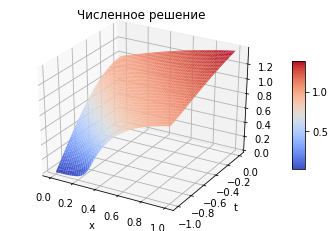

In [42]:
fig = plt.figure()
ax = fig.gca(projection='3d')
tm, xm = np.meshgrid(t, x)
surf = ax.plot_surface(tm, xm, u, cmap='coolwarm')
plt.ylabel('t')
plt.xlabel('x')
plt.title('Численное решение')
fig.colorbar(surf, shrink=0.5, aspect=8)

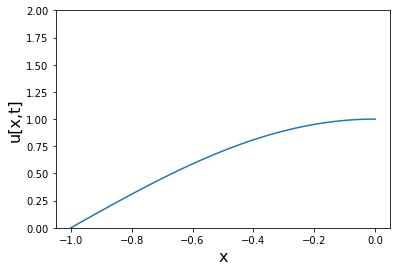

In [54]:
fig, ax = plt.subplots()
ax.set_ylim(0, 2)
plt.xlabel('x', fontsize=16)
plt.ylabel('u[x,t]', fontsize=16)

line = ax.plot(x, u[..., 0])[0]

def init():
    line.set_ydata([np.nan]*len(x))
    return line,

def animate(i):
    line.set_ydata(u[..., i])
    return line,

anim = animation.FuncAnimation(fig, animate, interval=10)
writervideo = animation.FFMpegWriter(fps=60)

In [12]:
N = 500
x1 = np.linspace(-1, 0, N)

def t1(x,c):
    return c/(-2*np.sin(np.pi*c/2)*np.exp(-(np.sin(np.pi*c/2))**2)) + x/(2*np.sin(np.pi*c/2)*np.exp(-(np.sin(np.pi*c/2))**2))

fig = plt.figure()
ax = fig.gca()

for i in range(1, N):
    ax.plot(x1, t1(x1, x1[i]))

ax.set_ylim(0, 2)

TypeError: 'numpy.ndarray' object is not callable